In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Input, BatchNormalization, Dropout, Dense, Conv1D, SeparableConv1D, Activation, Add, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, roc_auc_score

Using TensorFlow backend.


In [ ]:
DROPOUT = 0.25

def build_resnet(input_shape, n_feature_maps, nb_classes):
    x = Input(shape=(input_shape))
    conv_x = BatchNormalization()(x)
    conv_x = Conv1D(n_feature_maps, kernel_size=3, strides=1, padding='same')(conv_x)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Dropout(DROPOUT)(conv_x)
    conv_y = Conv1D(n_feature_maps, kernel_size=3, strides=1, padding='same')(conv_x)
    conv_y = BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
    conv_y = Dropout(DROPOUT)(conv_y)
    conv_z = Conv1D(n_feature_maps, kernel_size=3, strides=1, padding='same')(conv_y)
    conv_z = BatchNormalization()(conv_z)
    conv_z = Dropout(DROPOUT)(conv_z)
    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        shortcut_y = Conv1D(n_feature_maps, kernel_size=1, strides=1, padding='same')(x)
        shortcut_y = BatchNormalization()(shortcut_y)
    else:
        shortcut_y = BatchNormalization()(x)
    y = Add()([shortcut_y, conv_z])
    y = Activation('relu')(y)
    x1 = y
    conv_x = Conv1D(n_feature_maps*2, kernel_size=3, strides=1, padding='same')(x1)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Dropout(DROPOUT)(conv_x)
    conv_y = Conv1D(n_feature_maps*2, kernel_size=3, strides=1, padding='same')(conv_x)
    conv_y = BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
    conv_y = Dropout(DROPOUT)(conv_y)
    conv_z = Conv1D(n_feature_maps*2, kernel_size=3, strides=1, padding='same')(conv_y)
    conv_z = BatchNormalization()(conv_z)
    conv_z = Dropout(DROPOUT)(conv_z)
    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = Conv1D(n_feature_maps*2, kernel_size=1, strides=1, padding='same')(x1)
        shortcut_y = BatchNormalization()(shortcut_y)
    else:
        shortcut_y = BatchNormalization()(x1)
    shortcut_y = Dropout(DROPOUT)(shortcut_y)
    y = Add()([shortcut_y, conv_z])
    y = Activation('relu')(y)
    y = Dropout(DROPOUT)(y)
    x1 = y
    conv_x = Conv1D(n_feature_maps*2, kernel_size=3, strides=1, padding='same')(x1)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Dropout(DROPOUT)(conv_x)
    conv_y = Conv1D(n_feature_maps*2, kernel_size=3, strides=1, padding='same')(conv_x)
    conv_y = BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
    conv_y = Dropout(DROPOUT)(conv_y)
    conv_z = Conv1D(n_feature_maps*2, kernel_size=3, strides=1, padding='same')(conv_y)
    conv_z = BatchNormalization()(conv_z)
    conv_z = Dropout(DROPOUT)(conv_z)
    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = Conv1D(n_feature_maps*2, kernel_size=1, strides=1, padding='same')(x1)
        shortcut_y = BatchNormalization()(shortcut_y)
    else:
        shortcut_y = BatchNormalization()(x1)
    shortcut_y = Dropout(DROPOUT)(shortcut_y)
    y = Add()([shortcut_y, conv_z])
    y = Activation('relu')(y)
    y = Dropout(DROPOUT)(y)
    full = GlobalAveragePooling1D()(y)
    out = Dense(nb_classes, activation='softmax')(full)
    return x, out

In [2]:
DROPOUT = 0.25

def build_resnet(input_shape, n_feature_maps, nb_classes):
    x = Input(shape=(input_shape))
    conv_x = Conv1D(n_feature_maps*2, kernel_size=3, strides=1, padding='same')(x)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Dropout(DROPOUT)(conv_x)
    conv_y = Conv1D(n_feature_maps*2, kernel_size=3, strides=1, padding='same')(conv_x)
    conv_y = BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
    conv_y = Dropout(DROPOUT)(conv_y)
    conv_z = Conv1D(n_feature_maps*2, kernel_size=3, strides=1, padding='same')(conv_y)
    conv_z = BatchNormalization()(conv_z)
    conv_z = Dropout(DROPOUT)(conv_z)
    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = Conv1D(n_feature_maps*2, kernel_size=1, strides=1, padding='same')(x)
        shortcut_y = BatchNormalization()(shortcut_y)
    else:
        shortcut_y = BatchNormalization()(x1)
    shortcut_y = Dropout(DROPOUT)(shortcut_y)
    y = Add()([shortcut_y, conv_z])
    y = Activation('relu')(y)
    y = Dropout(DROPOUT)(y)
    full = GlobalAveragePooling1D()(conv_z)
    out = Dense(nb_classes, activation='softmax')(full)
    return x, out

In [3]:
FOLDS = 5
PADDING = 50
MAX_POWER = 9

# Prepare training batches
input_data = pk.load(open('input_data3.pkl', 'rb'))
target_data = pk.load(open('target_data3.pkl', 'rb'))
model_input = []
model_target = []
for i, t in zip(input_data, target_data):
    model_input.append(np.concatenate([np.zeros((PADDING - 1, i.shape[1])), i])[:PADDING,:])
    model_target.append(np.argmax(t))
model_input = np.array(model_input)
model_target = np.array(model_target)

#keys, values = np.unique(model_target, return_counts=True)
#values = (1 / values) / max((1 / values))
#class_weight = dict(zip(keys, values))
class_weight = dict(zip(np.arange(target_data[0].size), np.ones((target_data[0].size,))))

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True)
mms = MinMaxScaler()

dimention = []
auc = []
kappa = []
for dim in np.power(2, np.arange(MAX_POWER+1)):
    print(f'nodes: {dim}')
    aucs = []
    kappas = []
    
    # Prepare k-fold training and test sets
    for train_index, test_index in skf.split(model_input, model_target):
        model_target[train_index.astype(int)]
        X_train_raw, X_test_raw = model_input[train_index], model_input[test_index]
        y_train_raw, y_test_raw = model_target[train_index], model_target[test_index]

        X_train = np.stack(X_train_raw)
        X_test = np.stack(X_test_raw)

        y_train = np.zeros((y_train_raw.size, y_train_raw.max() + 1))
        y_train[np.arange(y_train_raw.size),y_train_raw] = 1
        y_test = np.zeros((y_test_raw.size, y_test_raw.max() + 1))
        y_test[np.arange(y_test_raw.size),y_test_raw] = 1

        # Make the resnet
        x, y = build_resnet(X_train.shape[1:], dim, target_data[0].size)
        model = Model(inputs=x, outputs=y)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        #print(model.summary())
        es = EarlyStopping(monitor='val_loss', patience=5, min_delta=0, restore_best_weights=True) 
        model.fit(X_train, y_train, class_weight=class_weight, epochs=1000, validation_split=0.25, callbacks=[es])

        # Get the average auc and kappa for all affects and folds
        y_pred = model.predict(X_test, batch_size=1)
        for y_t, y_p in zip(y_test.T, y_pred.T):
            y_p = mms.fit_transform(y_p.reshape(-1, 1))
            aucs.append(roc_auc_score(y_t, y_p))
            kappas.append(cohen_kappa_score(y_t, np.around(y_p)))

    dimention.append(dim)
    auc.append(np.mean(aucs))
    kappa.append(np.mean(kappas))
    print(f'auc: {auc[-1]}')
    print(f'kappa: {kappa[-1]}')

nodes: 1

Train on 1854 samples, validate on 618 samples
Epoch 1/1000
1854/1854 [==============================] - 2s 1ms/step - loss: 1.3493 - accuracy: 0.6251 - val_loss: 1.3091 - val_accuracy: 0.8447
Epoch 2/1000
1854/1854 [==============================] - 0s 209us/step - loss: 1.2719 - accuracy: 0.7891 - val_loss: 1.2222 - val_accuracy: 0.8447
Epoch 3/1000
1854/1854 [==============================] - 0s 210us/step - loss: 1.1867 - accuracy: 0.7961 - val_loss: 1.1289 - val_accuracy: 0.8447
Epoch 4/1000
1854/1854 [==============================] - 0s 211us/step - loss: 1.0941 - accuracy: 0.8042 - val_loss: 1.0365 - val_accuracy: 0.8447
Epoch 5/1000
1854/1854 [==============================] - 0s 209us/step - loss: 0.9963 - accuracy: 0.8091 - val_loss: 0.9474 - val_accuracy: 0.8430
Epoch 6/1000
1854/1854 [==============================] - 0s 221us/step - loss: 0.9085 - accuracy: 0.8069 - val_loss: 0.8594 - val_accuracy: 0.8430
Epoch 7/1000
1854/1854 [==============================] -

Epoch 15/1000
1856/1856 [==============================] - 0s 214us/step - loss: 0.5853 - accuracy: 0.8200 - val_loss: 0.6267 - val_accuracy: 0.8401
Epoch 16/1000
1856/1856 [==============================] - 0s 218us/step - loss: 0.5829 - accuracy: 0.8200 - val_loss: 0.6431 - val_accuracy: 0.8401
Epoch 17/1000
1856/1856 [==============================] - 0s 214us/step - loss: 0.5760 - accuracy: 0.8200 - val_loss: 0.6362 - val_accuracy: 0.8401
Epoch 18/1000
1856/1856 [==============================] - 0s 205us/step - loss: 0.5735 - accuracy: 0.8200 - val_loss: 0.6367 - val_accuracy: 0.8401
Epoch 19/1000
1856/1856 [==============================] - 0s 238us/step - loss: 0.5703 - accuracy: 0.8200 - val_loss: 0.6393 - val_accuracy: 0.8401
Epoch 20/1000
1856/1856 [==============================] - 0s 217us/step - loss: 0.5689 - accuracy: 0.8200 - val_loss: 0.6394 - val_accuracy: 0.8401
Train on 1857 samples, validate on 619 samples
Epoch 1/1000
1857/1857 [==============================] - 1

Epoch 5/1000
1854/1854 [==============================] - 0s 222us/step - loss: 0.7766 - accuracy: 0.8177 - val_loss: 0.7039 - val_accuracy: 0.8495
Epoch 6/1000
1854/1854 [==============================] - 0s 226us/step - loss: 0.6960 - accuracy: 0.8177 - val_loss: 0.6511 - val_accuracy: 0.8495
Epoch 7/1000
1854/1854 [==============================] - 0s 211us/step - loss: 0.6500 - accuracy: 0.8177 - val_loss: 0.6085 - val_accuracy: 0.8495
Epoch 8/1000
1854/1854 [==============================] - 0s 215us/step - loss: 0.6231 - accuracy: 0.8177 - val_loss: 0.5899 - val_accuracy: 0.8495
Epoch 9/1000
1854/1854 [==============================] - 0s 214us/step - loss: 0.6086 - accuracy: 0.8177 - val_loss: 0.5963 - val_accuracy: 0.8495
Epoch 10/1000
1854/1854 [==============================] - 0s 213us/step - loss: 0.5976 - accuracy: 0.8177 - val_loss: 0.5906 - val_accuracy: 0.8495
Epoch 11/1000
1854/1854 [==============================] - 0s 210us/step - loss: 0.5968 - accuracy: 0.8177 - va

1856/1856 [==============================] - 0s 213us/step - loss: 0.5669 - accuracy: 0.8173 - val_loss: 0.6395 - val_accuracy: 0.8401
Epoch 21/1000
1856/1856 [==============================] - 0s 217us/step - loss: 0.5639 - accuracy: 0.8179 - val_loss: 0.6382 - val_accuracy: 0.8401
Epoch 22/1000
1856/1856 [==============================] - 0s 218us/step - loss: 0.5660 - accuracy: 0.8157 - val_loss: 0.6395 - val_accuracy: 0.8384
Epoch 23/1000
1856/1856 [==============================] - 0s 213us/step - loss: 0.5653 - accuracy: 0.8179 - val_loss: 0.6409 - val_accuracy: 0.8368
Train on 1857 samples, validate on 619 samples
Epoch 1/1000
1857/1857 [==============================] - 1s 601us/step - loss: 1.3085 - accuracy: 0.5423 - val_loss: 1.2547 - val_accuracy: 0.8449
Epoch 2/1000
1857/1857 [==============================] - 0s 225us/step - loss: 1.1474 - accuracy: 0.8040 - val_loss: 1.1140 - val_accuracy: 0.8449
Epoch 3/1000
1857/1857 [==============================] - 0s 233us/step - l

Epoch 11/1000
1854/1854 [==============================] - 0s 232us/step - loss: 0.5535 - accuracy: 0.8220 - val_loss: 0.6768 - val_accuracy: 0.8188
Train on 1854 samples, validate on 619 samples
Epoch 1/1000
1854/1854 [==============================] - 1s 630us/step - loss: 1.3115 - accuracy: 0.4676 - val_loss: 1.2183 - val_accuracy: 0.8481
Epoch 2/1000
1854/1854 [==============================] - 0s 228us/step - loss: 1.1156 - accuracy: 0.7756 - val_loss: 0.9985 - val_accuracy: 0.8481
Epoch 3/1000
1854/1854 [==============================] - 0s 238us/step - loss: 0.8984 - accuracy: 0.8015 - val_loss: 0.7954 - val_accuracy: 0.8481
Epoch 4/1000
1854/1854 [==============================] - 0s 236us/step - loss: 0.7345 - accuracy: 0.8058 - val_loss: 0.6579 - val_accuracy: 0.8481
Epoch 5/1000
1854/1854 [==============================] - 0s 235us/step - loss: 0.6389 - accuracy: 0.8123 - val_loss: 0.6055 - val_accuracy: 0.8481
Epoch 6/1000
1854/1854 [==============================] - 0s 235

1854/1854 [==============================] - 0s 238us/step - loss: 0.5701 - accuracy: 0.8161 - val_loss: 0.5813 - val_accuracy: 0.8528
Epoch 8/1000
1854/1854 [==============================] - 0s 235us/step - loss: 0.5642 - accuracy: 0.8166 - val_loss: 0.5921 - val_accuracy: 0.8511
Epoch 9/1000
1854/1854 [==============================] - 0s 239us/step - loss: 0.5514 - accuracy: 0.8107 - val_loss: 0.5943 - val_accuracy: 0.8511
Epoch 10/1000
1854/1854 [==============================] - 0s 235us/step - loss: 0.5518 - accuracy: 0.8182 - val_loss: 0.5970 - val_accuracy: 0.8463
Epoch 11/1000
1854/1854 [==============================] - 0s 236us/step - loss: 0.5454 - accuracy: 0.8172 - val_loss: 0.5995 - val_accuracy: 0.8528
Train on 1854 samples, validate on 619 samples
Epoch 1/1000
1854/1854 [==============================] - 1s 716us/step - loss: 1.2510 - accuracy: 0.6138 - val_loss: 1.0893 - val_accuracy: 0.8530
Epoch 2/1000
1854/1854 [==============================] - 0s 238us/step - lo

Epoch 3/1000
1854/1854 [==============================] - 0s 254us/step - loss: 0.6329 - accuracy: 0.8204 - val_loss: 0.6334 - val_accuracy: 0.8368
Epoch 4/1000
1854/1854 [==============================] - 0s 256us/step - loss: 0.5653 - accuracy: 0.8225 - val_loss: 0.6169 - val_accuracy: 0.8368
Epoch 5/1000
1854/1854 [==============================] - 0s 254us/step - loss: 0.5565 - accuracy: 0.8145 - val_loss: 0.6237 - val_accuracy: 0.8368
Epoch 6/1000
1854/1854 [==============================] - 0s 259us/step - loss: 0.5434 - accuracy: 0.8236 - val_loss: 0.6325 - val_accuracy: 0.8336
Epoch 7/1000
1854/1854 [==============================] - 0s 262us/step - loss: 0.5402 - accuracy: 0.8188 - val_loss: 0.6305 - val_accuracy: 0.8368
Epoch 8/1000
1854/1854 [==============================] - 0s 253us/step - loss: 0.5220 - accuracy: 0.8279 - val_loss: 0.6386 - val_accuracy: 0.8368
Epoch 9/1000
1854/1854 [==============================] - 0s 249us/step - loss: 0.5353 - accuracy: 0.8252 - val_

Epoch 2/1000
1857/1857 [==============================] - 1s 271us/step - loss: 0.7397 - accuracy: 0.7938 - val_loss: 0.6242 - val_accuracy: 0.8384
Epoch 3/1000
1857/1857 [==============================] - 0s 264us/step - loss: 0.5792 - accuracy: 0.8142 - val_loss: 0.6287 - val_accuracy: 0.8384
Epoch 4/1000
1857/1857 [==============================] - 0s 263us/step - loss: 0.5389 - accuracy: 0.8207 - val_loss: 0.6233 - val_accuracy: 0.8384
Epoch 5/1000
1857/1857 [==============================] - 0s 266us/step - loss: 0.5419 - accuracy: 0.8201 - val_loss: 0.6180 - val_accuracy: 0.8384
Epoch 6/1000
1857/1857 [==============================] - 1s 271us/step - loss: 0.5416 - accuracy: 0.8169 - val_loss: 0.6194 - val_accuracy: 0.8384
Epoch 7/1000
1857/1857 [==============================] - 0s 265us/step - loss: 0.5138 - accuracy: 0.8234 - val_loss: 0.6178 - val_accuracy: 0.8336
Epoch 8/1000
1857/1857 [==============================] - 0s 265us/step - loss: 0.5105 - accuracy: 0.8250 - val_

1857/1857 [==============================] - 1s 326us/step - loss: 0.5402 - accuracy: 0.8180 - val_loss: 0.6156 - val_accuracy: 0.8417
Epoch 5/1000
1857/1857 [==============================] - 1s 325us/step - loss: 0.5300 - accuracy: 0.8180 - val_loss: 0.6172 - val_accuracy: 0.8417
Epoch 6/1000
1857/1857 [==============================] - 1s 325us/step - loss: 0.5204 - accuracy: 0.8218 - val_loss: 0.6243 - val_accuracy: 0.8417
Epoch 7/1000
1857/1857 [==============================] - 1s 325us/step - loss: 0.5041 - accuracy: 0.8288 - val_loss: 0.6379 - val_accuracy: 0.8288
auc: 0.7109865754335076
kappa: 0.10702149960351026
nodes: 128
Train on 1854 samples, validate on 618 samples
Epoch 1/1000
1854/1854 [==============================] - 3s 1ms/step - loss: 1.0130 - accuracy: 0.6807 - val_loss: 0.6273 - val_accuracy: 0.8447
Epoch 2/1000
1854/1854 [==============================] - 1s 403us/step - loss: 0.5915 - accuracy: 0.8155 - val_loss: 0.6136 - val_accuracy: 0.8447
Epoch 3/1000
1854/

Epoch 2/1000
1854/1854 [==============================] - 1s 549us/step - loss: 0.5610 - accuracy: 0.8172 - val_loss: 0.6472 - val_accuracy: 0.8333
Epoch 3/1000
1854/1854 [==============================] - 1s 549us/step - loss: 0.5308 - accuracy: 0.8188 - val_loss: 0.6479 - val_accuracy: 0.8333
Epoch 4/1000
1854/1854 [==============================] - 1s 541us/step - loss: 0.5292 - accuracy: 0.8274 - val_loss: 0.6270 - val_accuracy: 0.8333
Epoch 5/1000
1854/1854 [==============================] - 1s 548us/step - loss: 0.5048 - accuracy: 0.8285 - val_loss: 0.6434 - val_accuracy: 0.8333
Epoch 6/1000
1854/1854 [==============================] - 1s 544us/step - loss: 0.4952 - accuracy: 0.8430 - val_loss: 0.6272 - val_accuracy: 0.8333
Train on 1854 samples, validate on 619 samples
Epoch 1/1000
1854/1854 [==============================] - 3s 2ms/step - loss: 0.9434 - accuracy: 0.7136 - val_loss: 0.5765 - val_accuracy: 0.8546
Epoch 2/1000
1854/1854 [==============================] - 1s 552us/

1856/1856 [==============================] - 2s 1ms/step - loss: 0.5665 - accuracy: 0.8103 - val_loss: 0.6454 - val_accuracy: 0.8481
Epoch 3/1000
1856/1856 [==============================] - 2s 1ms/step - loss: 0.5546 - accuracy: 0.8147 - val_loss: 0.6314 - val_accuracy: 0.8481
Epoch 4/1000
1856/1856 [==============================] - 2s 1ms/step - loss: 0.5390 - accuracy: 0.8098 - val_loss: 0.6207 - val_accuracy: 0.8481
Epoch 5/1000
1856/1856 [==============================] - 2s 1ms/step - loss: 0.5213 - accuracy: 0.8227 - val_loss: 0.6376 - val_accuracy: 0.8481
Epoch 6/1000
1856/1856 [==============================] - 2s 1ms/step - loss: 0.5164 - accuracy: 0.8254 - val_loss: 0.6077 - val_accuracy: 0.8481
Train on 1857 samples, validate on 619 samples
Epoch 1/1000
1857/1857 [==============================] - 4s 2ms/step - loss: 0.8794 - accuracy: 0.7157 - val_loss: 0.5979 - val_accuracy: 0.8465
Epoch 2/1000
1857/1857 [==============================] - 2s 1ms/step - loss: 0.5749 - acc

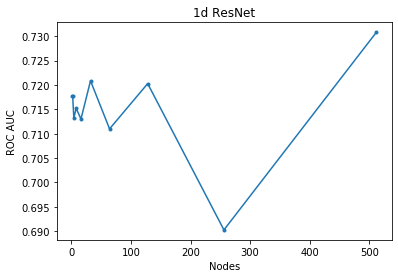

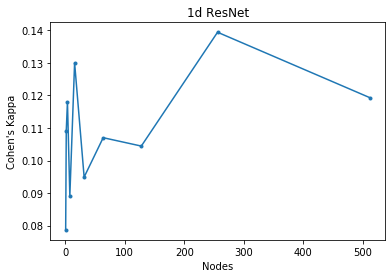

In [4]:
plt.figure()
plt.plot(dimention[:MAX_POWER+1], auc[:MAX_POWER+1], marker='.')
plt.xlabel('Nodes')
plt.ylabel('ROC AUC')
plt.title('1d ResNet')
plt.show()

plt.figure()
plt.plot(dimention[:MAX_POWER+1], kappa[:MAX_POWER+1], marker='.')
plt.xlabel('Nodes')
plt.ylabel('Cohen\'s Kappa')
plt.title('1d ResNet')
plt.show()